In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import pandas as pd

In [ ]:
!pip install GEOparse

In [ ]:
import GEOparse
gse = GEOparse.get_GEO("GSE62564") #GSE62564 has EFS data
gse2 = GEOparse.get_GEO("GSE49711") #GSE49711 has microarray data

In [5]:
#Load into dataframes
clinical = gse.phenotype_data
clinical2 = gse2.phenotype_data

In [6]:
#Formatting and merginf dataframes
clinical = clinical.reset_index()
clinical2 = clinical2.reset_index()
clinical = pd.concat([clinical, clinical2], axis=1)

In [7]:
#Get just the columns I'm interested in and rename them
reduced_clinical = clinical[['index', 'title', 'characteristics_ch1.2.Sex', 'characteristics_ch1.2.age', 'characteristics_ch1.3.efs day', 'characteristics_ch1.5.high risk', 'characteristics_ch1.6.inss stage', 'characteristics_ch1.4.efs bin', 'characteristics_ch1.8.progression', 'characteristics_ch1.11.d_fav_all', 'characteristics_ch1.9.death from disease', 'characteristics_ch1.4.mycn status']]

In [8]:
#Rename columns and drop the duplicates
reduced_clinical.columns = ['GSM', 'GSM2', 'SampID2', 'SampID', 'Sex', 'Age', 'EFS Time', 'High Risk', 'Stage', 'EFS Bin', 'Progression', 'Favourability', 'Death from Disease', 'MYCN Amplification']
reduced_clinical = reduced_clinical.drop(['GSM2', 'SampID2'], axis=1)

In [9]:
reduced_clinical.loc[reduced_clinical["Favourability"].isna(), 'Favourability'] = 0

In [11]:
reduced_clinical.loc[reduced_clinical["Stage"] == "4S", 'Stage'] = 5

In [12]:
#Load microarray data file
microarray_data = pd.read_csv('/gdrive/My Drive/project/GSE49711_SEQC_NB_MAV_G_log2.csv', sep='\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
#Format microarray dataframe so it. can be merged with clinical data
microarray_data = microarray_data.transpose()
microarray_data.columns = microarray_data.iloc[0]
microarray_data = microarray_data.drop(['#Gene'])
#Genes I'm interested in
genes = microarray_data[['TP53', 'NTRK1', 'PTPN6', 'ACE2', 'TMPRSS2', 'CXCL10', 'AGTR1', 'IFITM3', 'MYCN']]
genes = genes[1:]
genes = genes.reset_index()
genes = genes.rename(columns={"index": "SampID"})

In [14]:
#Merge clinical data and microarray data
all = pd.merge(reduced_clinical, genes, on='SampID')

In [15]:
all = all[all['MYCN Amplification'] != 'N/A']

In [ ]:
all.loc[all["EFS Time"].astype(float) < 1825, 'EFS'] = 0
all.loc[all["EFS Time"].astype(float) >=1825, 'EFS'] = 1

In [16]:
#Calculate z-scores
from scipy.stats import zscore
all['TP53_z'] = zscore(all['TP53'].astype(float))
all['NTRK1_z'] = zscore(all['NTRK1'].astype(float))
all['PTPN6_z'] = zscore(all['PTPN6'].astype(float))
all['ACE2_z'] = zscore(all['ACE2'].astype(float))
all['TMPRSS2_z'] = zscore(all['TMPRSS2'].astype(float))
all['CXCL10_z'] = zscore(all['CXCL10'].astype(float))
all['AGTR1_z'] = zscore(all['AGTR1'].astype(float))
all['IFITM3_z'] = zscore(all['IFITM3'].astype(float))

## **Cox Regression**

In [ ]:
!pip install lifelines

In [21]:
all.loc[all["Sex"] == "F", 'Sex'] = 0
all.loc[all["Sex"] == "M", 'Sex'] = 1

In [22]:
#Drop columns without MYCN Amplification data
all = all[all['MYCN Amplification'] != 'N/A']

In [48]:
#Convert all columns to float
all['EFS Bin'] = all['EFS Bin'].astype(float)
all['EFS Time'] = all['EFS Time'].astype(float)
all['Sex'] = all['Sex'].astype(float)
all['Age'] = all['Age'].astype(float)
all['High Risk'] = all['High Risk'].astype(float)
all['Stage'] = all['Stage'].astype(float)
all['Favourability'] = all['Favourability'].astype(float)
all['MYCN Amplification'] = all['MYCN Amplification'].astype(float)
all['TP53'] = all['TP53'].astype(float)
all['NTRK1'] = all['NTRK1'].astype(float)
all['PTPN6'] = all['PTPN6'].astype(float)
all['ACE2'] = all['ACE2'].astype(float)
all['TMPRSS2'] = all['TMPRSS2'].astype(float)
all['CXCL10'] = all['CXCL10'].astype(float)
all['AGTR1'] = all['AGTR1'].astype(float)
all['IFITM3'] = all['IFITM3'].astype(float)
all['MYCN'] = all['MYCN'].astype(float)

In [150]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
all_data = all[['Sex', 'Age', 'Stage', 'High Risk', 'EFS Time', 'EFS Bin', 'MYCN Amplification', "ACE2_z", 'TMPRSS2_z', 'IFITM3_z', 'CXCL10_z', 'AGTR1_z']]
cph.fit(all_data, 'EFS Time', event_col='EFS Bin')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 493 total observations, 313 right-censored observations>
             duration col = 'EFS Time'
                event col = 'EFS Bin'
      baseline estimation = breslow
   number of observations = 493
number of events observed = 180
   partial log-likelihood = -999.19
         time fit was run = 2021-02-26 14:40:13 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
Sex                 -0.25       0.78       0.16            -0.56             0.06                 0.57                 1.07
Age                  0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
Stage                0.26       1.29       0.08             0.10             0.41                 1.11                 1.50
High Risk            1.22       3.38       0.24             0.75             1.69                 2.12                 5.41
MYCN Amplification   0.17       1.19       0.21            -0.25             0.59                 0.78                 1.80
ACE2_z               0.11       1.12       0.08            -0.05             0.28                 0.95                 1.32
TMPRSS2_z            0.02       1.02       0.08            -0.14             0.18                 0.87                 1.20
IFITM3_z            -0.16       0.86       0.09            -0.34             0.03                 0.71                 1.03
CXCL10_z             0.10       1.11       0.09            -0.08             0.28                 0.92                 1.33
AGTR1_z              0.11       1.12       0.08            -0.04             0.27                 0.96                 1.31

                       z      p   -log2(p)
covariate                                 
Sex                -1.56   0.12       3.08
Age                 2.59   0.01       6.72
Stage               3.31 <0.005      10.04
High Risk           5.10 <0.005      21.47
MYCN Amplification  0.80   0.42       1.24
ACE2_z              1.35   0.18       2.51
TMPRSS2_z           0.27   0.79       0.34
IFITM3_z           -1.67   0.09       3.40
CXCL10_z            1.09   0.28       1.86
AGTR1_z             1.40   0.16       2.63
---
Concordance = 0.73
Partial AIC = 2018.38
log-likelihood ratio test = 142.47 on 10 df
-log2(p) of ll-ratio test = 82.66

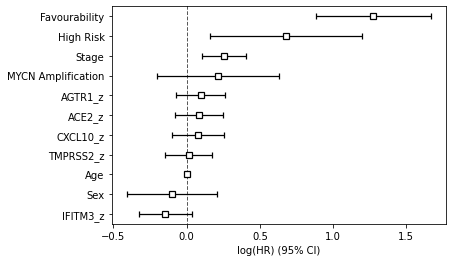

In [121]:
cph.plot()

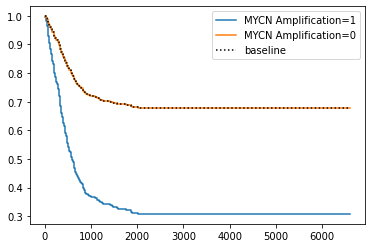

In [109]:
cph.plot_partial_effects_on_outcome(covariates='MYCN Amplification', values=[1, 0])

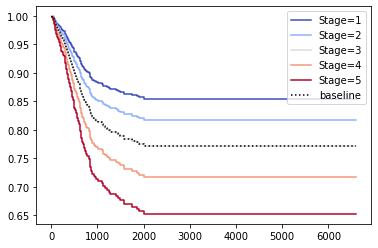

In [70]:
cph.plot_partial_effects_on_outcome(covariates='Stage', values=[1, 2, 3, 4, 5], cmap='coolwarm')

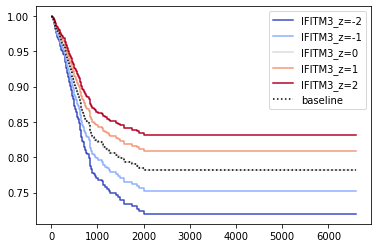

In [122]:
cph.plot_partial_effects_on_outcome(covariates='IFITM3_z', values=[-2,-1,-0,1,2], cmap='coolwarm')

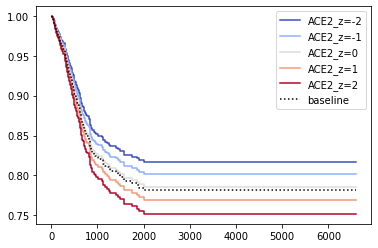

In [123]:
cph.plot_partial_effects_on_outcome(covariates='ACE2_z', values=[-2,-1,-0,1,2], cmap='coolwarm')

### **MYCN Amplified**

In [77]:
amp = all.loc[all['MYCN Amplification'] == 1]

In [124]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
all_data = amp[['EFS Time', 'EFS Bin', "ACE2_z", 'TMPRSS2_z', 'IFITM3_z', 'CXCL10_z', 'AGTR1_z']]
cph.fit(all_data, 'EFS Time', event_col='EFS Bin')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 92 total observations, 32 right-censored observations>
             duration col = 'EFS Time'
                event col = 'EFS Bin'
      baseline estimation = breslow
   number of observations = 92
number of events observed = 60
   partial log-likelihood = -237.76
         time fit was run = 2021-02-26 14:16:49 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ACE2_z      0.12       1.12       0.16            -0.20             0.43                 0.82                 1.53
TMPRSS2_z  -0.00       1.00       0.15            -0.29             0.29                 0.75                 1.33
IFITM3_z   -0.20       0.82       0.16            -0.51             0.11                 0.60                 1.12
CXCL10_z    0.09       1.09       0.13            -0.16             0.34                 0.85                 1.41
AGTR1_z     0.18       1.19       0.16            -0.13             0.49                 0.87                 1.63

              z    p   -log2(p)
covariate                      
ACE2_z     0.72 0.47       1.09
TMPRSS2_z -0.01 0.99       0.01
IFITM3_z  -1.25 0.21       2.23
CXCL10_z   0.70 0.48       1.05
AGTR1_z    1.11 0.27       1.91
---
Concordance = 0.56
Partial AIC = 485.52
log-likelihood ratio test = 3.01 on 5 df
-log2(p) of ll-ratio test = 0.52

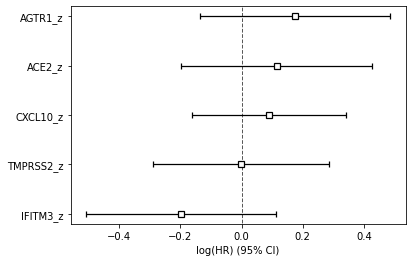

In [125]:
cph.plot()

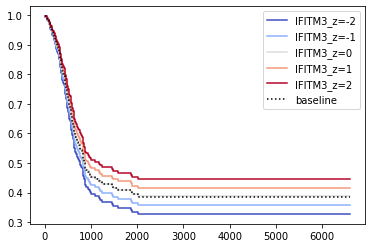

In [100]:
cph.plot_partial_effects_on_outcome(covariates='IFITM3_z', values=[-2,-1,-0,1,2], cmap='coolwarm')

In [104]:
all['MYCN Amplification'].value_counts()

0.0    401
1.0     92
Name: MYCN Amplification, dtype: int64

In [83]:
not_amp = all.loc[all['MYCN Amplification'] == 0]

In [126]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
all_data = not_amp[['EFS Time', 'EFS Bin', "ACE2_z", 'TMPRSS2_z', 'IFITM3_z', 'CXCL10_z', 'AGTR1_z']]
cph.fit(all_data, 'EFS Time', event_col='EFS Bin')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 401 total observations, 281 right-censored observations>
             duration col = 'EFS Time'
                event col = 'EFS Bin'
      baseline estimation = breslow
   number of observations = 401
number of events observed = 120
   partial log-likelihood = -691.80
         time fit was run = 2021-02-26 14:17:00 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ACE2_z      0.15       1.16       0.10            -0.04             0.34                 0.96                 1.41
TMPRSS2_z  -0.00       1.00       0.10            -0.19             0.19                 0.82                 1.21
IFITM3_z   -0.03       0.97       0.13            -0.28             0.22                 0.76                 1.24
CXCL10_z    0.14       1.15       0.14            -0.13             0.42                 0.87                 1.52
AGTR1_z    -0.12       0.89       0.09            -0.30             0.06                 0.74                 1.06

              z    p   -log2(p)
covariate                      
ACE2_z     1.51 0.13       2.94
TMPRSS2_z -0.02 0.99       0.02
IFITM3_z  -0.23 0.81       0.30
CXCL10_z   1.01 0.31       1.68
AGTR1_z   -1.32 0.19       2.43
---
Concordance = 0.56
Partial AIC = 1393.61
log-likelihood ratio test = 5.61 on 5 df
-log2(p) of ll-ratio test = 1.53

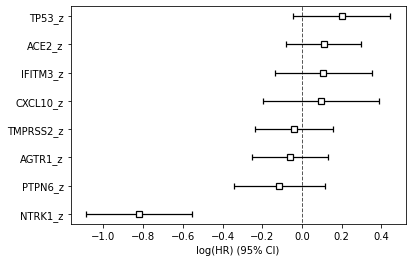

In [97]:
cph.plot()

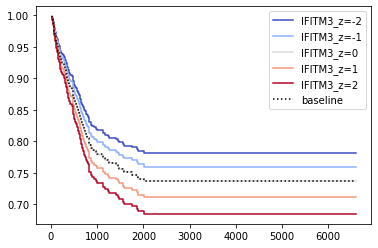

In [103]:
cph.plot_partial_effects_on_outcome(covariates='IFITM3_z', values=[-2,-1,-0,1,2], cmap='coolwarm')

### **Favourability**

In [85]:
fav = all.loc[all['Favourability'] == 0]

In [127]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
all_data = fav[['EFS Time', 'EFS Bin', "ACE2_z", 'TMPRSS2_z', 'IFITM3_z', 'CXCL10_z', 'AGTR1_z']]
cph.fit(all_data, 'EFS Time', event_col='EFS Bin')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 419 total observations, 313 right-censored observations>
             duration col = 'EFS Time'
                event col = 'EFS Bin'
      baseline estimation = breslow
   number of observations = 419
number of events observed = 106
   partial log-likelihood = -617.75
         time fit was run = 2021-02-26 14:21:18 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ACE2_z      0.21       1.23       0.11            -0.00             0.41                 1.00                 1.51
TMPRSS2_z   0.01       1.01       0.10            -0.19             0.21                 0.83                 1.24
IFITM3_z   -0.07       0.93       0.13            -0.33             0.18                 0.72                 1.20
CXCL10_z    0.02       1.02       0.13            -0.23             0.27                 0.79                 1.31
AGTR1_z    -0.07       0.93       0.10            -0.27             0.12                 0.77                 1.12

              z    p   -log2(p)
covariate                      
ACE2_z     1.95 0.05       4.29
TMPRSS2_z  0.09 0.93       0.11
IFITM3_z  -0.57 0.57       0.82
CXCL10_z   0.14 0.89       0.17
AGTR1_z   -0.76 0.45       1.16
---
Concordance = 0.55
Partial AIC = 1245.50
log-likelihood ratio test = 4.77 on 5 df
-log2(p) of ll-ratio test = 1.17

In [87]:
unfav = all.loc[all['Favourability'] == 1]

In [128]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
all_data = unfav[['EFS Time', 'EFS Bin', "ACE2_z", 'TMPRSS2_z', 'IFITM3_z', 'CXCL10_z', 'AGTR1_z']]
cph.fit(all_data, 'EFS Time', event_col='EFS Bin')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 74 total observations, 0 right-censored observations>
             duration col = 'EFS Time'
                event col = 'EFS Bin'
      baseline estimation = breslow
   number of observations = 74
number of events observed = 74
   partial log-likelihood = -244.57
         time fit was run = 2021-02-26 14:21:39 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ACE2_z     -0.11       0.89       0.13            -0.36             0.14                 0.70                 1.15
TMPRSS2_z  -0.08       0.92       0.15            -0.37             0.21                 0.69                 1.23
IFITM3_z   -0.13       0.88       0.15            -0.42             0.17                 0.66                 1.18
CXCL10_z   -0.08       0.92       0.12            -0.31             0.15                 0.73                 1.16
AGTR1_z     0.26       1.29       0.17            -0.08             0.59                 0.92                 1.81

              z    p   -log2(p)
covariate                      
ACE2_z    -0.87 0.38       1.39
TMPRSS2_z -0.55 0.58       0.78
IFITM3_z  -0.86 0.39       1.35
CXCL10_z  -0.71 0.47       1.07
AGTR1_z    1.48 0.14       2.85
---
Concordance = 0.60
Partial AIC = 499.14
log-likelihood ratio test = 6.00 on 5 df
-log2(p) of ll-ratio test = 1.71

### **Age**

In [89]:
young = all.loc[all['Age'] < 547]

In [117]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
all_data = young[['EFS Time', 'EFS Bin', "ACE2_z", 'TMPRSS2_z', 'IFITM3_z', 'CXCL10_z', 'AGTR1_z']]
cph.fit(all_data, 'EFS Time', event_col='EFS Bin')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 302 total observations, 236 right-censored observations>
             duration col = 'EFS Time'
                event col = 'EFS Bin'
      baseline estimation = breslow
   number of observations = 302
number of events observed = 66
   partial log-likelihood = -362.60
         time fit was run = 2021-02-26 14:08:31 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ACE2_z      0.31       1.36       0.14             0.03             0.58                 1.04                 1.79
TMPRSS2_z   0.06       1.06       0.12            -0.18             0.30                 0.83                 1.36
IFITM3_z    0.01       1.01       0.17            -0.33             0.35                 0.72                 1.41
CXCL10_z   -0.25       0.78       0.16            -0.57             0.07                 0.57                 1.07
AGTR1_z    -0.16       0.86       0.14            -0.43             0.12                 0.65                 1.12

              z    p   -log2(p)
covariate                      
ACE2_z     2.21 0.03       5.21
TMPRSS2_z  0.48 0.63       0.66
IFITM3_z   0.06 0.95       0.07
CXCL10_z  -1.52 0.13       2.96
AGTR1_z   -1.12 0.26       1.94
---
Concordance = 0.57
Partial AIC = 735.20
log-likelihood ratio test = 9.56 on 5 df
-log2(p) of ll-ratio test = 3.49

In [92]:
old = all.loc[all['Age'] >= 547]

In [118]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
all_data = old[['EFS Time', 'EFS Bin', "ACE2_z", 'TMPRSS2_z', 'IFITM3_z', 'CXCL10_z', 'AGTR1_z']]
cph.fit(all_data, 'EFS Time', event_col='EFS Bin')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 191 total observations, 77 right-censored observations>
             duration col = 'EFS Time'
                event col = 'EFS Bin'
      baseline estimation = breslow
   number of observations = 191
number of events observed = 114
   partial log-likelihood = -546.04
         time fit was run = 2021-02-26 14:08:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ACE2_z      0.05       1.05       0.10            -0.15             0.25                 0.86                 1.28
TMPRSS2_z  -0.12       0.89       0.11            -0.33             0.10                 0.72                 1.10
IFITM3_z   -0.06       0.95       0.11            -0.28             0.17                 0.76                 1.18
CXCL10_z   -0.00       1.00       0.10            -0.20             0.19                 0.82                 1.21
AGTR1_z    -0.01       0.99       0.08            -0.17             0.16                 0.84                 1.17

              z    p   -log2(p)
covariate                      
ACE2_z     0.50 0.61       0.70
TMPRSS2_z -1.06 0.29       1.79
IFITM3_z  -0.49 0.63       0.67
CXCL10_z  -0.03 0.98       0.03
AGTR1_z   -0.07 0.94       0.09
---
Concordance = 0.55
Partial AIC = 1102.08
log-likelihood ratio test = 2.22 on 5 df
-log2(p) of ll-ratio test = 0.29

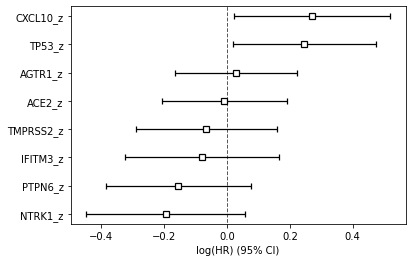

In [99]:
cph.plot()